# 功能函数

In [13]:
import os, logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

def reconImagesByFFT(kdata, size):
    if isinstance(size, int):
        size = (size, size)

    try:
        # experiments, echoes, slices, views, views2, samples = kdata.shape
        idata = np.fft.fftshift(np.fft.ifftn(kdata, s=(size[0], kdata.shape[4], size[1]),
                                             axes=(3, 4, 5)),
                                axes=(3, 4, 5))
    except Exception as e:
        return []

    idata = np.abs(idata)
    idata /= idata.max()

    images = []
    for e in range(idata.shape[0]):
        for k in range(idata.shape[1]):
            for s in range(idata.shape[2]):
                for v2 in range(idata.shape[4]):
                    images.append(idata[e, k, s, :, v2, :])

    return images

def yanglei(kdatas, nbin=8, v=0):
    kdata_obj = kdatas[0]
    kdata_nos = [_ for _ in kdatas[1:] if _ is not None]

    if len(kdata_nos) <= 0:
        return kdata_obj

    if (not isinstance(nbin, int)) or nbin <= 0:
        logging.warning('The nbin(=%d) must be an integer greater than 0.' % (nbin,))
        return kdata_obj

    npb = kdata_nos[0].shape[5] // nbin

    if (nbin * npb) != kdata_nos[0].shape[5]:
        logging.warning('The nbin(=%d) must be divisible by number of samples(=%d).' % (nbin, kdata_nos[0].shape[5]))
    else:
        idata_obj = np.fft.fft(kdata_obj)
        idata_nos = np.array([np.fft.fft(kdata_nos[i]) for i in range(len(kdata_nos))])

        X = idata_nos[:, 0, 0, 0, v, 0, :]
        y = idata_obj[0, 0, 0, v, 0, :]
        c = np.zeros((idata_nos.shape[0], nbin), dtype=y.dtype)

        for i in range(c.shape[1]):
            rng = range(i * npb, (i + 1) * npb)
            _ = np.linalg.lstsq(X[:, rng].T, y[rng], rcond=None)
            c[:, i] = _[0]

        idata_obj -= np.reshape(np.sum(c[:, None, None, None, None, None, :, None] *
                                       idata_nos.reshape((idata_nos.shape[0], idata_nos.shape[1], idata_nos.shape[2],
                                                          idata_nos.shape[3], idata_nos.shape[4], idata_nos.shape[5],
                                                          c.shape[1], -1)),
                                       axis=0),
                                idata_obj.shape)

        kdata_obj = np.fft.ifft(idata_obj)

    return kdata_obj

def loadMrd(fpath):
    try:
        with open(fpath, 'rb') as f:
            mrd = f.read()
    except Exception as e:
        print(e)
        return None

    if len(mrd) < 512:
        return None

    samples=int(0).from_bytes(mrd[0:4], byteorder='little', signed=True)
    views=int(0).from_bytes(mrd[4:8], byteorder='little', signed=True)
    views2=int(0).from_bytes(mrd[8:12], byteorder='little', signed=True)
    slices = int(0).from_bytes(mrd[12:16], byteorder='little', signed=True)
    # 16-18 Unspecified
    datatype=int(0).from_bytes(mrd[18:20], byteorder='little', signed=True)
    # 20-152 Unspecified
    echoes=int(0).from_bytes(mrd[152:156], byteorder='little', signed=True)
    experiments=int(0).from_bytes(mrd[156:160], byteorder='little', signed=True)

    nele = experiments*echoes*slices*views*views2*samples

    if datatype & 0xf == 0:
        dt='u1'
        eleSize = 1
    elif datatype & 0xf == 1:
        dt='i1'
        eleSize = 1
    elif datatype & 0xf == 2:
        dt='i2'
        eleSize = 2
    elif datatype & 0xf == 3:
        dt='i2'
        eleSize = 2
    elif datatype & 0xf == 4:
        dt='i4'
        eleSize = 4
    elif datatype & 0xf == 5:
        dt='f4'
        eleSize = 4
    elif datatype & 0xf == 6:
        dt='f8'
        eleSize = 8
    else:
        print('Unknown data type in the MRD file!')
        return None
    if datatype & 0x10:
        eleSize *= 2

    #
    # XXX - The value of NO_AVERAGES in PPR cannot be used to
    #       calculate the data size.
    #
    posPPR = mrd.rfind(b'\x00')
    if posPPR == -1:
        print('Corrupted MRD file!')
        return None
    posPPR += 1
    dataSize = posPPR - 512 - 120
    if dataSize < nele * eleSize:
        print('Corrupted MRD file!')
        return None

    navg = dataSize // (nele * eleSize)

    if navg > 1:
        data = np.zeros((experiments,echoes,slices,views,views2,samples),
                        dtype=(np.complex128 if dt == 'f8' else np.complex64) if (datatype & 0x10) else (np.float64 if dt == 'f8' else np.float32))

    offset = 512
    for i in range(navg):
        x = np.frombuffer(mrd[offset:],
                          dtype=[('re', '<'+dt), ('im', '<'+dt)] if (datatype & 0x10) else ('<'+dt),
                          count=nele)
        if dt in ('f4', 'f8'):
            pass
        else:
            x = x.astype(np.float32)

        if datatype & 0x10:
            if dt in ('f8',):
                x = x.view(np.complex128)
            else:
                x = x.view(np.complex64)

        x = x.reshape((experiments,echoes,slices,views,views2,samples))

        offset += nele * eleSize

        if navg > 1:
            data += x

    if navg > 1:
        data /= navg
    else:
        data = x

    return data

def load_data(scan_or_noise='scan', set_id=1, exp_id=1):
    files = [os.path.join(os.path.abspath(os.path.curdir), 'datasets', 'HYC',    
                              'set %d'%set_id, '%s data' % scan_or_noise, 'exp%d'%exp_id,
                              '%s%d.mrd' % (scan_or_noise, _)) for _ in range(1,5)] # set 1，exp1注意空格
    return [loadMrd(file) for file in files]

def get_SNR(image, size=10):
    width = image.shape[0]
    signal = np.mean(image[width//2-size:width//2+size, width//2-size:width//2+size])
    noise = (np.std(image[:size, :size]) + np.std(image[-size:, -size:]) + np.std(image[:size, -size:]) + np.std(image[-size:, :size]))/4
    
    return signal/noise

def get_avgSNR(images):
    return sum([get_SNR(image) for image in images])/len(images)

if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
else:
    device = torch.device("cpu")   # 使用 CPU

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")


def complex_mae_loss(input, target):
    return torch.mean(torch.abs(input - target))


def complex_mse_loss(input, target):
    return torch.mean(torch.abs(input - target)**2)


首先，尝试将杨磊算法的Loss函数改为L1Loss，看看效果如何

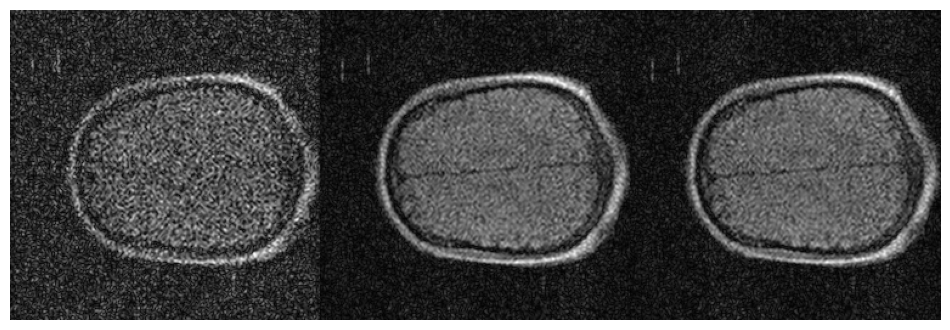

5.662037703217343
5.6499643254574705


In [14]:
from scipy.optimize import minimize
def lad_regression_complex(cX, cy):
    X = np.array([cX.real, cX.imag])
    y = np.array([cy.real, cy.imag])
    
    def lad_loss_complex(coef, X, y):
        real_residuals = y[0] - X[0] @ coef[:3] + X[1] @ coef[3:]
        imag_residuals = y[1] - X[1] @ coef[:3] - X[0] @ coef[3:]
        # return np.sum(np.abs(real_residuals) + np.abs(imag_residuals))
        # return np.sum(real_residuals**2 + imag_residuals**2) # 作为改函数的检测，当配置为L2loss效果与np.linalg.lstsq相同
        return np.sum(np.sqrt(real_residuals**2 + imag_residuals**2)) # 绝对值和
        
    initial_guess = np.ones((cX.shape[1] * 2))/cX.shape[1]
    result = minimize(lad_loss_complex, initial_guess, args=(X, y))

    _ = np.array(result.x[:3] + 1j*result.x[3:], dtype=np.complex128)
    return _  

def L1yanglei(kdatas, nbin=8, v=0):
    kdata_obj = kdatas[0]
    kdata_nos = [_ for _ in kdatas[1:] if _ is not None]

    if len(kdata_nos) <= 0:
        return kdata_obj

    if (not isinstance(nbin, int)) or nbin <= 0:
        logging.warning('The nbin(=%d) must be an integer greater than 0.' % (nbin,))
        return kdata_obj

    npb = kdata_nos[0].shape[5] // nbin

    if (nbin * npb) != kdata_nos[0].shape[5]:
        logging.warning('The nbin(=%d) must be divisible by number of samples(=%d).' % (nbin, kdata_nos[0].shape[5]))
    else:
        idata_obj = np.fft.fft(kdata_obj)
        idata_nos = np.array([np.fft.fft(kdata_nos[i]) for i in range(len(kdata_nos))])

        X = idata_nos[:, 0, 0, 0, v, 0, :]
        y = idata_obj[0, 0, 0, v, 0, :]
        c = np.zeros((idata_nos.shape[0], nbin), dtype=y.dtype)

        for i in range(c.shape[1]):
            rng = range(i * npb, (i + 1) * npb)
            # _ = np.linalg.lstsq(X[:, rng].T, y[rng], rcond=None)
            _ = lad_regression_complex(X[:, rng].T, y[rng])
            c[:, i] = _

        idata_obj -= np.reshape(np.sum(c[:, None, None, None, None, None, :, None] *
                                       idata_nos.reshape((idata_nos.shape[0], idata_nos.shape[1], idata_nos.shape[2],
                                                          idata_nos.shape[3], idata_nos.shape[4], idata_nos.shape[5],
                                                          c.shape[1], -1)),
                                       axis=0),
                                idata_obj.shape)

        kdata_obj = np.fft.ifft(idata_obj)

    return kdata_obj

datas = load_data(scan_or_noise='scan', set_id=4)

yanglei_images = reconImagesByFFT(yanglei(datas), 256)
L1yanglei_images = reconImagesByFFT(L1yanglei(datas), 256)
measured_images = reconImagesByFFT(datas[0], 256)

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

plt.subplot(1, 3, 1)
plt.imshow(measured_images[13], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(yanglei_images[13], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(L1yanglei_images[13], cmap='gray')
plt.axis('off')

plt.show()

print(get_avgSNR(yanglei_images))
print(get_avgSNR(L1yanglei_images))


发现L2Loss效果比L1略好，并非想象中的L1优于L2

此外还发现Loss为`np.sum(np.abs(real_residuals) + np.abs(imag_residuals))`的效果大于L1和L2

但是这3者之间的差距并不大

# Dataset1
数据域：时域

输入：一整个采样行

In [15]:
class HYCDataset1(Dataset):
    def __init__(self, set_id=4, scan_or_noise='noise', exp_id=1):
        datas = load_data(scan_or_noise=scan_or_noise, set_id=set_id, exp_id=exp_id)
        samples = datas[0].shape[-1]
        self.obj = np.fft.fft(datas[0]).reshape(-1, samples)
        self.nos = np.array([np.fft.fft(data).reshape(-1, samples) for data in datas[1:]])

    def __len__(self):
        return self.obj.shape[0]
    
    def __getitem__(self, idx):
        nos = self.nos[:, idx, :]
        obj = self.obj[idx, :]

        return nos, obj

# Dataset2
数据域： 时域

输入： 一个采样点

In [16]:
class HYCDataset2(Dataset):
    def __init__(self, set_id=4, scan_or_noise='noise', exp_id=1):
        datas = load_data(scan_or_noise=scan_or_noise, set_id=set_id, exp_id=exp_id)
        self.obj = np.fft.fft(datas[0]).flatten()
        self.nos = np.array([np.fft.fft(data).flatten() for data in datas[1:]], dtype=np.complex128)
        assert self.obj.shape[0] == self.nos.shape[1]

    def __len__(self):
        return self.obj.shape[0]
    
    def __getitem__(self, idx):
        nos = self.nos[:, idx]
        obj = self.obj[idx]

        return nos, obj

# Net1, Net2: 使用一层全连接层

In [20]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 128, 128, dtype=torch.complex128),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    
if not os.path.exists('models/model1.pth'):
    model = Net1()
    
    learning_rate = 1e-3
    batch_size = 4
    
    loss_fn = complex_mae_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    
    train_data = HYCDataset1(exp_id=1)
    text_data = HYCDataset1(exp_id=2)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(text_data, batch_size=batch_size, shuffle=True)
    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
        
    torch.save(model.state_dict(), "models/model1.pth")

Epoch 1
-------------------------------
loss: 142.616424  [    4/ 3072]
loss: 130.379799  [  404/ 3072]
loss: 110.101396  [  804/ 3072]
loss: 98.225688  [ 1204/ 3072]
loss: 81.235149  [ 1604/ 3072]
loss: 73.628468  [ 2004/ 3072]
loss: 68.533778  [ 2404/ 3072]
loss: 61.347259  [ 2804/ 3072]
Avg loss: 61.183140 

Epoch 2
-------------------------------
loss: 53.783566  [    4/ 3072]
loss: 53.836718  [  404/ 3072]
loss: 59.969590  [  804/ 3072]
loss: 55.728781  [ 1204/ 3072]
loss: 56.941371  [ 1604/ 3072]
loss: 54.695068  [ 2004/ 3072]
loss: 56.770082  [ 2404/ 3072]
loss: 56.287292  [ 2804/ 3072]
Avg loss: 57.143012 

Epoch 3
-------------------------------
loss: 50.930601  [    4/ 3072]
loss: 53.315415  [  404/ 3072]
loss: 50.701541  [  804/ 3072]
loss: 56.257975  [ 1204/ 3072]
loss: 53.735917  [ 1604/ 3072]
loss: 53.441026  [ 2004/ 3072]
loss: 54.574183  [ 2404/ 3072]
loss: 55.720595  [ 2804/ 3072]
Avg loss: 57.276692 

Epoch 4
-------------------------------
loss: 51.634604  [    4/ 30

In [18]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 1, dtype=torch.complex128),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    
if not os.path.exists('models/model2.pth'):
    model = Net2()
    
    learning_rate = 1e-3
    batch_size = 4
    
    loss_fn = complex_mae_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    
    train_data = HYCDataset2(exp_id=1)
    text_data = HYCDataset2(exp_id=2)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(text_data, batch_size=batch_size, shuffle=True)
    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
        
    torch.save(model.state_dict(), "models/model2.pth")

Epoch 1
-------------------------------
loss: 111.274272  [    4/393216]
loss: 186.165490  [  404/393216]
loss: 157.014250  [  804/393216]
loss: 110.924549  [ 1204/393216]
loss: 75.476417  [ 1604/393216]
loss: 66.484445  [ 2004/393216]
loss: 88.417915  [ 2404/393216]
loss: 147.760644  [ 2804/393216]
loss: 143.329883  [ 3204/393216]
loss: 86.537043  [ 3604/393216]
loss: 67.643347  [ 4004/393216]
loss: 160.735151  [ 4404/393216]
loss: 55.829704  [ 4804/393216]
loss: 178.909105  [ 5204/393216]
loss: 131.073315  [ 5604/393216]
loss: 152.336418  [ 6004/393216]
loss: 112.206776  [ 6404/393216]
loss: 118.386771  [ 6804/393216]
loss: 117.354801  [ 7204/393216]
loss: 155.172900  [ 7604/393216]
loss: 103.345267  [ 8004/393216]
loss: 150.440837  [ 8404/393216]
loss: 87.087653  [ 8804/393216]
loss: 101.752066  [ 9204/393216]
loss: 135.474235  [ 9604/393216]
loss: 135.727712  [10004/393216]
loss: 181.835708  [10404/393216]
loss: 165.348251  [10804/393216]
loss: 123.536839  [11204/393216]
loss: 103.

# 评估

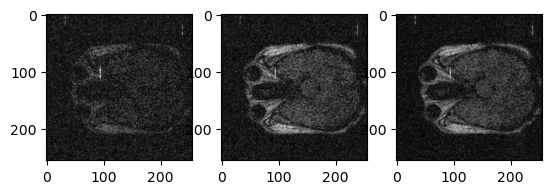

4.011523303023565
7.744596066303492
5.827775807865018


In [22]:
dataloader1 = DataLoader(HYCDataset1(scan_or_noise='scan'), batch_size=1, shuffle=False)
dataloader2 = DataLoader(HYCDataset2(scan_or_noise='scan'), batch_size=1, shuffle=False)
measured = load_data(scan_or_noise='scan', set_id=4)[0]

model1 = Net1()
model1.load_state_dict(torch.load("models/model1.pth"))

model2 = Net2()
model2.load_state_dict(torch.load("models/model2.pth"))

model1.eval()
model2.eval()

def reconstract(dataloader, model):
    kdata = []
    check = []
    with torch.no_grad():
        for batch, (nos, obj) in enumerate(dataloader):
            pred = model(nos)
            kdata.append(obj - pred)
            check.append(obj)
            
    kdata = np.hstack(kdata).reshape(1, 1, 1, 128, 24, 128)
    check = np.hstack(check).reshape(1, 1, 1, 128, 24, 128)
    kdata = np.fft.ifft(kdata)
    check = np.fft.ifft(check)
    assert np.abs(check-measured).sum() < 1e-6
    return kdata

measure_images = reconImagesByFFT(measured, 256)       
Net1_images = reconImagesByFFT(reconstract(dataloader1, model1), 256)
Net2_images = reconImagesByFFT(reconstract(dataloader2, model2), 256)

plt.subplot(1, 3, 1)
plt.imshow(measure_images[6], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(Net1_images[6], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(yanglei_images[6], cmap='gray')
plt.show()

print(get_SNR(measure_images[13]))
print(get_SNR(Net1_images[13]))
print(get_SNR(Net2_images[13]))


杨磊的avgSNR是5.66，Net1和Net2的效果都比杨磊好

Net1的效果比Net2好，说明在时域上的前后数据是具有相关性的，RNN很可能有效

_但是这里信噪比的值特别高可能是因为去掉了白噪声，分母下降特别多导致的比值高，图像显示Net1的信号部分图像清晰度并不比Net2好_

# RNN

## 将复数拆分为两个实数效果测试
pytorch中RNN对复数的支持并不好，因此需要将复数拆分为两个实数，我们先对Net1进行修改，测试效果


In [38]:
class HYCDataset1asFloat(Dataset):
    def __init__(self, set_id=4, scan_or_noise='noise', exp_id=1):
        datas = load_data(scan_or_noise=scan_or_noise, set_id=set_id, exp_id=exp_id)
        samples = datas[0].shape[-1]
        self.obj = np.fft.fft(datas[0]).reshape(-1, samples)
        self.nos = np.array([np.fft.fft(data).reshape(-1, samples) for data in datas[1:]])
        
        self.obj = np.concatenate([self.obj.real, self.obj.imag], axis=1, dtype=np.float64)
        self.nos = np.concatenate([self.nos.real, self.nos.imag], axis=2, dtype=np.float64)

    def __len__(self):
        return self.obj.shape[0]
    
    def __getitem__(self, idx):
        nos = self.nos[:, idx, :]
        obj = self.obj[idx, :]

        return nos, obj

class Net1asFloat(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6 * 128, 128 * 2, dtype=torch.float64),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
if not os.path.exists('models/model1asFloat.pth'):
    model = Net1asFloat()
    
    learning_rate = 1e-3
    batch_size = 4
    loss_fn = complex_mae_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    
    train_data = HYCDataset1asFloat(exp_id=1)
    text_data = HYCDataset1asFloat(exp_id=2)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(text_data, batch_size=batch_size, shuffle=True)
    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
        
    torch.save(model.state_dict(), "models/model1asFloat.pth")
    

Epoch 1
-------------------------------
loss: 94.280645  [    4/ 3072]
loss: 81.038491  [  404/ 3072]
loss: 73.920399  [  804/ 3072]
loss: 67.860061  [ 1204/ 3072]
loss: 57.970835  [ 1604/ 3072]
loss: 53.910317  [ 2004/ 3072]
loss: 49.911905  [ 2404/ 3072]
loss: 47.121695  [ 2804/ 3072]
Avg loss: 43.633726 

Epoch 2
-------------------------------
loss: 39.889076  [    4/ 3072]
loss: 36.206796  [  404/ 3072]
loss: 38.594277  [  804/ 3072]
loss: 37.519188  [ 1204/ 3072]
loss: 36.680359  [ 1604/ 3072]
loss: 36.640439  [ 2004/ 3072]
loss: 36.904607  [ 2404/ 3072]
loss: 37.478380  [ 2804/ 3072]
Avg loss: 38.488185 

Epoch 3
-------------------------------
loss: 29.854155  [    4/ 3072]
loss: 34.866797  [  404/ 3072]
loss: 33.323239  [  804/ 3072]
loss: 35.464464  [ 1204/ 3072]
loss: 33.603382  [ 1604/ 3072]
loss: 37.807510  [ 2004/ 3072]
loss: 36.960844  [ 2404/ 3072]
loss: 35.720813  [ 2804/ 3072]
Avg loss: 38.687532 

Epoch 4
-------------------------------
loss: 33.063924  [    4/ 3072]

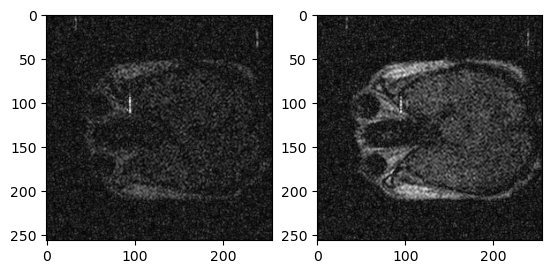

4.606368120434715


In [39]:
def float2complexReconstruct(model, dataloader):
    kdata = []
    check = []
    with torch.no_grad():
        for batch, (nos, obj) in enumerate(dataloader):
            pred = model(nos)
            kdata.append(obj - pred)
            check.append(obj)
            
    kdata = np.hstack(kdata).reshape(1, 1, 1, 128, 24, 2, 128)
    check = np.hstack(check).reshape(1, 1, 1, 128, 24, 2, 128)
    kdata = np.complex128(kdata[:, :, :, :, :, 0, :] + 1j * kdata[:, :, :, :, :, 1, :])
    check = np.complex128(check[:, :, :, :, :, 0, :] + 1j * check[:, :, :, :, :, 1, :])
    kdata = np.fft.ifft(kdata)
    check = np.fft.ifft(check)
    assert np.abs(check-measured).sum() < 1e-6
    return kdata

dataloader1asFloat = DataLoader(HYCDataset1asFloat(scan_or_noise='scan'), batch_size=1, shuffle=False)
measured = load_data(scan_or_noise='scan', set_id=4)[0]

model1asFloat = Net1asFloat()
model1asFloat.load_state_dict(torch.load("models/model1asFloat.pth"))
model1asFloat.eval()

Net1asFloat_images = reconImagesByFFT(float2complexReconstruct(model1asFloat, dataloader1asFloat), 256)
measure_images = reconImagesByFFT(measured, 256)

plt.subplot(1, 2, 1)
plt.imshow(measure_images[6], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Net1asFloat_images[6], cmap='gray')
plt.show()

print(get_avgSNR(Net1asFloat_images))


差距过大，所以是不能直接拆分为两个实数数组训练的